In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from yellowbrick.classifier import ROCAUC


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import logging
from datetime import datetime
from datetime import timedelta

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=DeprecationWarning) 

import sweetviz as sv
import matplotlib.pyplot as plt
import json
import tqdm

import pickle

In [3]:
import mytransformer as myt
from mytransformer import TS2SL

In [16]:

# check pycaret version
import pycaret as pycaret
print('PyCaret: %s' % pycaret.__version__)

PyCaret: 2.3.1


In [4]:
### Load the data
# folder = '../../data source/_anonymized/'
# declare some constants
folder = '_anonymized/'
sweetviz = True

# read the cleaned csv files

df = pd.read_csv(folder + 'dataset_4_modelling.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('Unnamed: 0 not existing in this file.')
    
logging.info('{} rows and {} columns read in the CSV file'.format(df.shape[0], df.shape[1]))
df.shape

(8902, 67)

In [9]:
df.head()

,SRC_UID,IS_STRATEGIC,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,EXPERIENCE,SOFTCLOSING,CNT_SHARE,QUANTITY,IN_FLOWS,...,FUND_AGE_BIN,DOWNLOADED_DOCUMENTS_BIN,BENCH_PERF_SLOPE,BENCH_PERF_SLOPE_ERROR,BENCH_VOL_SLOPE,BENCH_VOL_SLOPE_ERROR,NAV_PERF_SLOPE,NAV_PERF_SLOPE_ERROR,NAV_VOL_SLOPE,NAV_VOL_SLOPE_ERROR
0,206670688,0,0.000277,0.001631,1,0.0,0,12,5389079,69669121,...,7,0,-0.002294,0.005912,-0.000033,0.000171,-0.001929,0.004775,-0.000154,0.000694
1,206670688,0,0.000277,0.001631,1,0.0,0,12,5504541,89408248,...,7,0,-0.001882,0.004867,-0.000032,0.000159,-0.001646,0.003938,-0.000127,0.000652
2,206670688,0,0.000277,0.001631,1,0.0,0,12,4781963,68084125,...,7,0,-0.001614,0.004224,-0.000034,0.000128,-0.001485,0.003630,-0.000106,0.000647
3,206670688,0,0.000277,0.001631,1,0.0,0,12,4910848,104779215,...,7,0,-0.001358,0.003621,-0.000022,0.000126,-0.001052,0.002517,-0.000082,0.000607
4,206670688,0,0.000277,0.001631,1,0.0,0,12,4408949,65517596,...,7,0,-0.001117,0.003113,-0.000016,0.000112,-0.000743,0.001721,-0.000062,0.000610


In [54]:
df.columns

Index(['SRC_UID', 'IS_STRATEGIC', 'ADMINSTRATION_FEES', 'MANAGEMENT_FEES',
       'MULTI_MANAGER_STRUCTURE', 'EXPERIENCE', 'SOFTCLOSING', 'CNT_SHARE',
       'QUANTITY', 'IN_FLOWS', 'OUT_FLOWS', 'NET_FLOWS', 'AUM',
       'BENCH_PERF_1_MONTH', 'BENCH_PERF_1_YEAR', 'BENCH_PERF_3_MONTH',
       'BENCH_PERF_6_MONTH', 'BENCH_VOL_1_MONTH', 'BENCH_VOL_3_MONTH',
       'BENCH_VOL_6_MONTH', 'BENCH_VOLATILITY_1_YEAR', 'NAV_PERF_1_MONTH',
       'NAV_PERF_1_YEAR', 'NAV_PERF_3_MONTH', 'NAV_PERF_6_MONTH',
       'NAV_VOL_1_MONTH', 'NAV_VOL_3_MONTH', 'NAV_VOL_6_MONTH',
       'NAV_VOLATILITY_1_YEAR', 'BENCH_VOL_SINCE_INCEPT',
       'NAV_PERF_COMPOUND_CREATION', 'NAV_VOL_SINCE_INCEPT', 'FUND_SIZE',
       'SUB_FUNDS_SHARE_PARTS', 'SUB_FUNDS_SHARE_SIZE_SF_CCY',
       'DOWNLOADED_DOCUMENTS', 'WEIGHTED', 'PSU_SCORE', 'POSITIVE_RFP',
       'EVENT_IMPACT', 'COMPUTED_FLOWS', 'CHECKED', 'DIFF_FLOWS', 'THRESHOLD',
       'TARGET', 'RISK_LEVEL_VALUE', 'PRODUCT_STRATEGY', 'ASSET_NAME',
       'FUND_NAME', 

In [60]:
df['FLOWS_M1']=df['NET_FLOWS'].shift(1)
df['FLOWS_M2']=df['NET_FLOWS'].shift(2)
df[['NET_FLOWS','FLOWS_M1','FLOWS_M2']].dropna()

,NET_FLOWS,FLOWS_M1,FLOWS_M2
2,-95518684,15097645.0,-131827306.0
3,17638095,-95518684.0,15097645.0
4,-66598477,17638095.0,-95518684.0
5,-62096841,-66598477.0,17638095.0
6,-7631916,-62096841.0,-66598477.0
...,...,...,...
8897,7200259,1313987.0,7251823.0
8898,13760937,7200259.0,1313987.0
8899,24142098,13760937.0,7200259.0
8900,43657986,24142098.0,13760937.0


In [62]:
cols = ['FLOWS_M1','FLOWS_M2','FLOWS_MONTH',
       'FLOWS_YEAR','BENCH_PERF_SLOPE',
       'BENCH_PERF_SLOPE_ERROR', 'BENCH_VOL_SLOPE', 'BENCH_VOL_SLOPE_ERROR',
       'NAV_PERF_SLOPE', 'NAV_PERF_SLOPE_ERROR', 'NAV_VOL_SLOPE',
       'NAV_VOL_SLOPE_ERROR','TARGET']
df[cols]

,FLOWS_M1,FLOWS_M2,FLOWS_MONTH,FLOWS_YEAR,BENCH_PERF_SLOPE,BENCH_PERF_SLOPE_ERROR,BENCH_VOL_SLOPE,BENCH_VOL_SLOPE_ERROR,NAV_PERF_SLOPE,NAV_PERF_SLOPE_ERROR,NAV_VOL_SLOPE,NAV_VOL_SLOPE_ERROR,TARGET
0,NaN,NaN,1,2010,-0.002294,0.005912,-0.000033,0.000171,-0.001929,0.004775,-0.000154,0.000694,-1
1,-131827306.0,NaN,2,2010,-0.001882,0.004867,-0.000032,0.000159,-0.001646,0.003938,-0.000127,0.000652,1
2,15097645.0,-131827306.0,3,2010,-0.001614,0.004224,-0.000034,0.000128,-0.001485,0.003630,-0.000106,0.000647,-1
3,-95518684.0,15097645.0,4,2010,-0.001358,0.003621,-0.000022,0.000126,-0.001052,0.002517,-0.000082,0.000607,1
4,17638095.0,-95518684.0,5,2010,-0.001117,0.003113,-0.000016,0.000112,-0.000743,0.001721,-0.000062,0.000610,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,1313987.0,7251823.0,9,2020,0.002099,-0.006360,0.000035,0.000057,-0.017896,0.060428,-0.001291,0.055365,1
8898,7200259.0,1313987.0,10,2020,0.002086,-0.006345,0.000063,0.000007,-0.015975,0.034633,-0.012080,0.070153,1
8899,13760937.0,7200259.0,11,2020,0.002108,-0.006426,0.000040,0.000049,-0.011221,0.055799,-0.003275,0.059975,1
8900,24142098.0,13760937.0,12,2020,0.002106,-0.006438,0.000051,0.000043,-0.018773,0.074239,-0.005920,0.062375,1


In [63]:
from pycaret.classification import setup
from pycaret.classification import compare_models

In [64]:
dataset = df[cols].copy()
dataset.dropna(inplace=True)
dataset.shape

(8900, 13)

In [65]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)
data.shape, data_unseen.shape

((8010, 13), (890, 13))

In [66]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
# setup the dataset
grid = setup(data=data, target='TARGET', session_id=123, verbose=False)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.3.1
INFO:logs:Initializing setup()
INFO:logs:setup(display=None, profile_kwargs=None, profile=False, verbose=False, silent=False, log_data=False, log_profile=False, log_plots=False, experiment_name=None, log_experiment=False, session_id=123, html=True, custom_pipeline=None, use_gpu=False, n_jobs=-1, fold_groups=None, fold_shuffle=False, fold=10, fold_strategy=stratifiedkfold, data_split_stratify=False, data_split_shuffle=True, transform_target_method=box-cox, transform_target=False, fix_imbalance_method=None, fix_imbalance=False, interaction_threshold=0.01, feature_ratio=False, feature_interaction=False, feature_selection_method=classic, feature_selection_threshold=0.8, feature_selection=False, group_names=None, group_features=None, polynomial_threshold=0.1, trigonometry_features=False, polynomial_degree=2, polynomial_features=False, cluster_iter=20, create_clusters=False, remove_perfect_collin

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
FLOWS_M1,Numeric
FLOWS_M2,Numeric
FLOWS_MONTH,Categorical
FLOWS_YEAR,Categorical
BENCH_PERF_SLOPE,Numeric
BENCH_PERF_SLOPE_ERROR,Numeric
BENCH_VOL_SLOPE,Numeric
BENCH_VOL_SLOPE_ERROR,Numeric
NAV_PERF_SLOPE,Numeric
NAV_PERF_SLOPE_ERROR,Numeric


 y


INFO:logs:Creating grid variables
INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passt

In [67]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.4996,0.6808,0.4997,0.5020,0.4998,0.2491,0.2496,2.5670
lightgbm,Light Gradient Boosting Machine,0.4872,0.6713,0.4873,0.4885,0.4874,0.2305,0.2307,0.2490
rf,Random Forest Classifier,0.4863,0.6700,0.4865,0.4873,0.4864,0.2292,0.2294,0.7190
ada,Ada Boost Classifier,0.4861,0.6642,0.4863,0.4864,0.4860,0.2290,0.2292,0.2520
ridge,Ridge Classifier,0.4654,0.0000,0.4658,0.4647,0.4642,0.1982,0.1986,0.0150
lda,Linear Discriminant Analysis,0.4654,0.6462,0.4656,0.4659,0.4651,0.1980,0.1982,0.0330
et,Extra Trees Classifier,0.4499,0.6284,0.4499,0.4518,0.4502,0.1745,0.1747,0.6120
lr,Logistic Regression,0.4393,0.6268,0.4423,0.4193,0.3704,0.1617,0.1817,0.5430
knn,K Neighbors Classifier,0.4211,0.5900,0.4208,0.4262,0.4162,0.1310,0.1333,0.1420
dt,Decision Tree Classifier,0.4056,0.5542,0.4059,0.4052,0.4050,0.1085,0.1086,0.0560


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [68]:
best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
from pycaret.classification import tune_model

In [70]:
from pycaret.classification import create_model
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4617,0.6199,0.4640,0.4214,0.3863,0.1945,0.2186
1,0.4492,0.6251,0.4525,0.4750,0.3809,0.1767,0.1992
2,0.4421,0.6331,0.4454,0.4262,0.3763,0.1661,0.1855
3,0.4367,0.6356,0.4401,0.3980,0.3634,0.1580,0.1785
4,0.4349,0.6252,0.4383,0.4349,0.3717,0.1556,0.1743
5,0.4314,0.6301,0.4347,0.4215,0.3693,0.1502,0.1675
6,0.4339,0.6302,0.4366,0.4093,0.3605,0.1533,0.1734
7,0.4286,0.6304,0.4312,0.3121,0.3494,0.1453,0.1638
8,0.4357,0.6165,0.4383,0.4646,0.3727,0.1558,0.1750
9,0.4393,0.6224,0.4421,0.4303,0.3737,0.1615,0.1812


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 3
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [71]:
from pycaret.classification import tune_model
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4617,0.6199,0.4640,0.4214,0.3863,0.1945,0.2186
1,0.4492,0.6251,0.4525,0.4750,0.3809,0.1767,0.1992
2,0.4421,0.6331,0.4454,0.4262,0.3763,0.1661,0.1855
3,0.4367,0.6356,0.4401,0.3980,0.3634,0.1580,0.1785
4,0.4349,0.6252,0.4383,0.4349,0.3717,0.1556,0.1743
5,0.4314,0.6301,0.4347,0.4215,0.3693,0.1502,0.1675
6,0.4339,0.6302,0.4366,0.4093,0.3605,0.1533,0.1734
7,0.4286,0.6304,0.4312,0.3121,0.3494,0.1453,0.1638
8,0.4357,0.6165,0.4383,0.4646,0.3727,0.1558,0.1750
9,0.4393,0.6224,0.4421,0.4303,0.3737,0.1615,0.1812


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 4
INFO:logs:LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


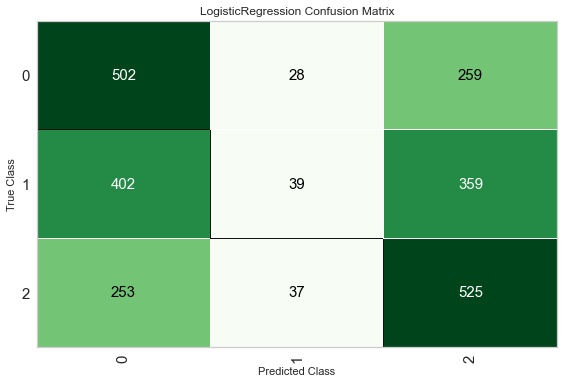

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [72]:
from pycaret.classification import plot_model
plot_model(tuned_lr, plot='confusion_matrix')

In [73]:
# create the log for this Notebook
now = datetime.now()
filename = 'logs/99-Pycaret-' + now.strftime("%m%d%Y") + '.log'

logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('')
logging.info('***************************************************************************************************')
logging.info('***                                                                                             ***')
logging.info('***   NEW RUN                                                                                   ***')
logging.info('***                                                                                             ***')
logging.info('***************************************************************************************************')

logging.info('I start to run your Notebook ! -- Good Luck :-) It is:  '+ now.strftime("%m/%d/%Y, %H:%M:%S"))


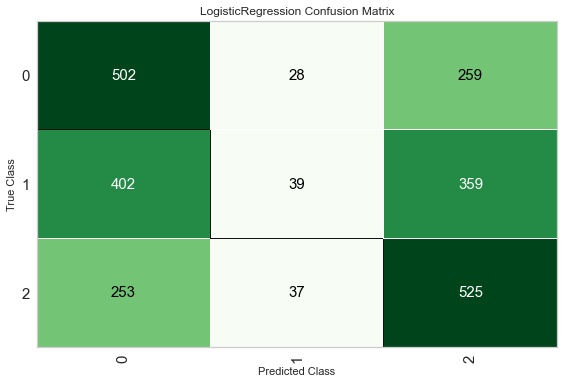

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [74]:
plot_model(tuned_lr, plot='confusion_matrix')

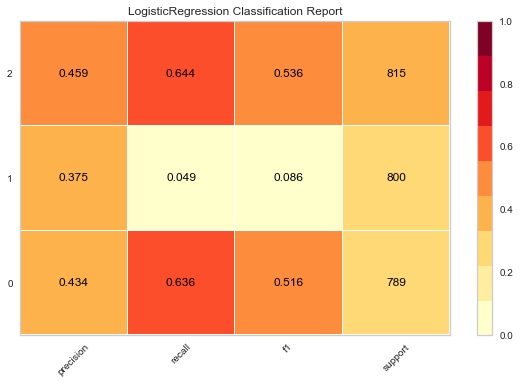

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [75]:
plot_model(tuned_lr, plot='class_report')

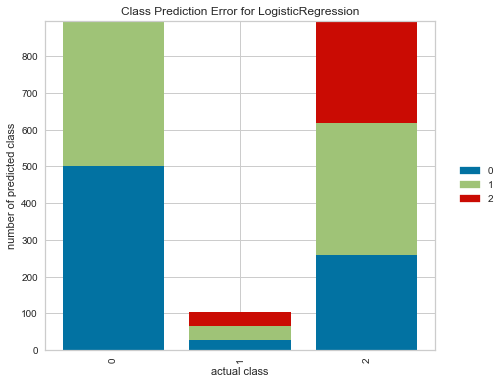

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [76]:
plot_model(tuned_lr, plot='error')

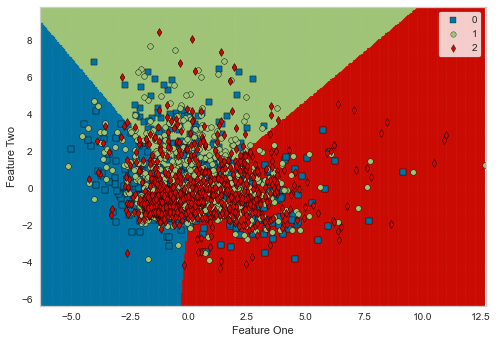

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [77]:
plot_model(tuned_lr, plot='boundary')